### Quick Note

In [143]:
#It should be noted that the methods are constructed in a method that utilizes only looping for the most part.
#This is to ensure that no method gets some unfair advantage by using slicing or numpy functions that
#call into C to perform faster operations.

# Initialization

In [144]:
#Import Package Cell

import numpy as np
import gzip
import os
from pathlib import Path
from io import StringIO
from scipy.io import mmread
import matplotlib.pyplot as plt
import time
import statistics
import pandas as pd

In [145]:
#Path Cell

cwd = os.getcwd()
path = str(Path(cwd).parent.absolute())

In [146]:
#Import Data Cell

N = 4
A_q2 = mmread(path + '//Data/mcca.mtx.gz').todense()
A_q3 = mmread(path + '//Data/young1c.mtx.gz').todense()
A_q3 = .5*(A_q3 + np.transpose(A_q3)) #Makes the A_q3 matrix symetric

# Setup Variables

In [147]:
max_iter = 200 #Max iterations
covergence_criterion = .002 #Convergence criterion

# Method Functions

In [148]:
#Gauss seidel Method Cell

def gauss_seidel(A , b , e):
    
    N = b.size
    
    x_k_m_1 = np.zeros(N)
    
    x_k = np.zeros(N)
    
    k = 1

    while k < max_iter: #Loops until a max iteration criterion, beyond which it is assumed that the method did not converge

        x_k_m_1[:] = x_k[:]
        
        for i in range(0 , N):

            x_k[i] = b[i]
            
            for j in range(0,i):
                x_k[i] -= A[i,j]*x_k[j]

            for j in range(i+1,N):
                x_k[i] -= A[i,j]*x_k[j]

            x_k[i] /= A[i,i]
            
        k += 1
        
        if((np.sqrt(np.sum(np.square(x_k - x_k_m_1)))/np.sqrt(np.sum(np.square(x_k))) < e ) & (k>2)): #Checks convergence
            
            return x_k , k

    k = -1; #Sets k equal to -1 to signify that convergence was not achieved
    
    return x_k , k

In [149]:
#Jacobi Method Cell

def jacobi(A , b , e):

    N = b.size
    
    x_k_m_1 = np.zeros(N)
    
    x_k = np.zeros(N)
    
    k = 1;

    while k < max_iter: #Loops until a max iteration criterion, beyond which it is assumed that the method did not converge
        
        x_k_m_1[:] = x_k[:]
        
        x_k = np.zeros(N)
        
        for i in range(0 , N):

            x_k[i] = b[i]
            
            for j in range(0,i):
                
                x_k[i] -= A[i,j]*x_k_m_1[j]

            for j in range(i+1,N):
                
                x_k[i] -= A[i,j]*x_k_m_1[j]

            x_k[i] /= A[i,i]
            
        k += 1
        
        if((np.sqrt(np.sum(np.square(x_k - x_k_m_1)))/np.sqrt(np.sum(np.square(x_k))) < e) & (k>2)): #Checks convergence
            
            return x_k , k

    k = -1; #Sets k equal to -1 to signify that convergence was not achieved
    
    return x_k , k

In [150]:
#Cholesky Method Cell

def cholesky(A):
    
    N = np.shape(A)[0] #Calculates N to be the side length of A
    
    L = np.zeros_like(A) #Creates L as a zeros matrix
    
    L[0,0] = np.sqrt(A[0,0]) #Sets the initial value of L[0,0] which is needed for calculation order to be correct
    
    for i in range(N): #Loops over all rows
        
        for j in range(0,i): #Loops over columns up to i
            
            L[i,j] = A[i,j]
            
            for k in range(0,j):
                
                L[i,j] -= L[j,k]*L[i,k]
                
            L[i,j] /= L[j,j]
            
        L[i,i] = A[i,i]
        
        for j in range(0,i):
            
            L[i,i] -= L[i,j] * L[i,j]
            
        L[i,i] = np.sqrt(L[i,i])
        
    return L , np.transpose(L)#.copy()

In [151]:
#Backwards Substitution Cell (Upper)

def backSubU(U , b):
    
    N = np.shape(U)[0]
    
    for j in range(N-1,-1,-1):
        
        for i in range(0,j):
            
            b[i] = b[i] - (b[j]*U[i,j]/U[j,j])
            
            U[i,j] = U[i,j] - (U[j,j]*U[i,j]/U[j,j])
            
    for i in range(N):
        
        b[i] = b[i]/U[i,i]

    return b

In [152]:
#Backwards Substitution Cell (Lower)

def backSubL(L , b):
    
    N = np.shape(L)[0]

    
    
    for j in range(0,N):
        for i in range(N-1,j,-1):
            b[i] = b[i] - (b[j]*L[i,j]/L[j,j])
            L[i,j] = L[i,j] - (L[j,j]*L[i,j]/L[j,j])
            #print(str(i) +" , "+str(j))
    #print(L) 
    #print(b)
    for i in range(N):
        b[i] = b[i]/L[i,i]
    #print(L)
    return b

# Question Two

### Non-diagonality of provided matrix and convergence issues

In [153]:
#The matrix provided for question 2 is not strictly diagonally dominant, which can be seen in this cell.

N = np.shape(A_q2)[0]

non_DD = []

for i in range(N):
    
    if (np.sum(np.abs(A_q2[i,:i])) + np.sum(np.abs(A_q2[i,(i+1):]))) > np.abs(A_q2[i,i]): #Checks if a row is diagonally dominant

        non_DD.append(i)

print("Rows")
print(non_DD)
print("are not diagonally dominant.")

Rows
[0, 3, 4, 7, 8, 12, 16, 18, 22, 23, 26, 30, 34, 38, 42, 45, 46, 47, 49, 50, 53, 54, 57, 58, 59, 61, 62, 63, 65, 66, 69, 70, 73, 74, 75, 77, 78, 81, 82, 83, 85, 86, 89, 90, 93, 94, 97, 98, 99, 101, 102, 103, 105, 106, 109, 110, 111, 113, 114, 117, 118, 121, 122, 125, 126, 127, 129, 130, 133, 134, 137, 138, 139, 141, 142, 145, 146, 149, 150, 151, 153, 154, 157, 158, 159, 161, 162, 165, 166, 169, 170, 171, 173, 174, 178]
are not diagonally dominant.


In [154]:
#This does not necessarily mean that the Gauss-Seidel and Jacobi methods will not converge, but I could not get it to.
#I tried altering the method of initial guess to a few variations. That did not work.
#Below I run 5 tests of each method and convergence (||delta x||<.2%) is not reached in 200 iterations.
#I would run more, but my implementation is quite slow.

converged = []

for l in range(10): #Run 10 tests of the Jacobi method and note any that converge
    
    x = (np.random.rand(N) - .5)*10 #Generate some random x vector

    b = np.ravel(np.matmul(A_q2,x)) #Find the corresponding b vector and reshape

    x_solved , k = jacobi(A_q2 , b , covergence_criterion)

    if (k != -1): #If k = -1 that means that the method failed to converge
        converged.append(l)

if (converged == []):
    print("No tests of the Jacobi method converged.")
else:
    print("Tests ")
    print(converged)
    print("of the Jacobi method converged.")

converged = []

for l in range(10): #Run 10 tests of the Gauss-Seidel method and note any that converge
    
    x = (np.random.rand(N) - .5)*10 #Generate some random x vector

    b = np.ravel(np.matmul(A_q2,x)) #Find the corresponding b vector and reshape

    _ , k = gauss_seidel(A_q2 , b , covergence_criterion)

    if (k != -1): #If k = -1 that means that the method failed to converge
        converged.append(l)

if (converged == []):
    print("No tests of the Gauus-Seidel method converged.")
else:
    print("Tests ")
    print(converged)
    print("of the Gauss-Seidel method converged.")

#Ignore the warning, it happens due to divergence of the process.

C:\Users\ashle\AppData\Local\Temp\ipykernel_5392\3203385750.py:35: RuntimeWarning: overflow encountered in square
  if((np.sqrt(np.sum(np.square(x_k - x_k_m_1)))/np.sqrt(np.sum(np.square(x_k))) < e) & (k>2)): #Checks convergence
C:\Users\ashle\AppData\Local\Temp\ipykernel_5392\3203385750.py:35: RuntimeWarning: invalid value encountered in scalar divide
  if((np.sqrt(np.sum(np.square(x_k - x_k_m_1)))/np.sqrt(np.sum(np.square(x_k))) < e) & (k>2)): #Checks convergence


No tests of the Jacobi method converged.


C:\Users\ashle\AppData\Local\Temp\ipykernel_5392\906193779.py:31: RuntimeWarning: overflow encountered in square
  if((np.sqrt(np.sum(np.square(x_k - x_k_m_1)))/np.sqrt(np.sum(np.square(x_k))) < e ) & (k>2)): #Checks convergence
C:\Users\ashle\AppData\Local\Temp\ipykernel_5392\906193779.py:31: RuntimeWarning: invalid value encountered in scalar divide
  if((np.sqrt(np.sum(np.square(x_k - x_k_m_1)))/np.sqrt(np.sum(np.square(x_k))) < e ) & (k>2)): #Checks convergence
C:\Users\ashle\AppData\Local\Temp\ipykernel_5392\906193779.py:22: RuntimeWarning: overflow encountered in scalar multiply
  x_k[i] -= A[i,j]*x_k[j]
C:\Users\ashle\AppData\Local\Temp\ipykernel_5392\906193779.py:22: RuntimeWarning: invalid value encountered in scalar multiply
  x_k[i] -= A[i,j]*x_k[j]


No tests of the Gauus-Seidel method converged.


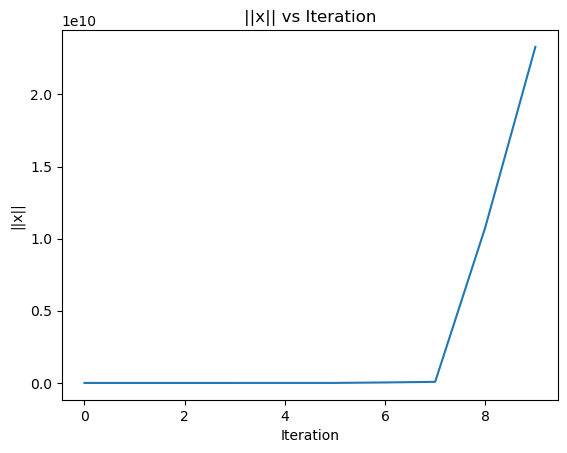

In [155]:
#To show the divergence of the process, 10 tests will be run and cut off after various max iterations and then plotted.
#There are much more efficient ways to do this, I simply chose this method so my method functions would not be returning anything but the final values.

x = (np.random.rand(N) - .5)*10 #Generate some random x vector

b = np.ravel(np.matmul(A_q2,x)) #Find the corresponding b vector and reshape

x_magnitudes = []

for l in range(10):

    max_iter = l

    x_solved , _ = jacobi(A_q2 , b , covergence_criterion)

    x_magnitudes.append(np.sqrt(np.sum(np.square(x_solved))))

iterations = np.arange(10)

plt.figure()

plt.plot(iterations , x_magnitudes)

plt.xlabel("Iteration")

plt.ylabel("||x||")

plt.title("||x|| vs Iteration")

plt.show(block = False)

#This plot shows the divergence of the x vector.

### Generating a diagonally dominant matrix

In [156]:
#To continue with the analysis, we must produce a matrix that will allow the method to converge.
#The easiest way to do so is with a diagonally dominant matrix.
#This generates the diagonally dominant matrix by setting the diagonal to a random multiple >1 of the sum of the off diagonals in each row
#and then multiplying by 1 or -1 at random.

A_q2_g = np.zeros_like(A_q2)

A_q2_g[:,:] = A_q2[:,:]

for i in range(180):

    A_q2_g[i,i] = (np.sum(np.abs(A_q2_g[i,:i])) + np.sum(np.abs(A_q2_g[i,(i+1):])))*(np.random.randint(0,1,1)[0]*2 - 1)*(np.random.rand(1)[0] + 1)


In [157]:
#To prove that the matrix is diagonally dominant this cell is shown

N = np.shape(A_q2_g)[0]

non_DD = []

for i in range(N):
    
    if (np.sum(np.abs(A_q2_g[i,:i])) + np.sum(np.abs(A_q2_g[i,(i+1):]))) > np.abs(A_q2_g[i,i]): #Checks if a row is diagonally dominant

        non_DD.append(i)

print("Rows")
print(non_DD)
print("are not diagonally dominant.")

Rows
[]
are not diagonally dominant.


### Time comparisons

In [158]:
#This cell runs both methods on b values generated with random ground truth x values.

max_iter = 200

N = np.shape(A_q2_g)[0]

T = 50

x_l = [] #This holds the list of ground truth x vectors generated

non_converged_j = [] #This is a list of all Jacobi tests that did not converge

x_solved_j = [] #This is a list of all x vectors solved for by the Jacobi method

k_l_j = [] #This is a list of all iteration counts of the Jacobi method

dt_l_j = [] #This is a list of all run times for the Jacobi method

non_converged_gs = [] #This is a list of all Gauss-Seidel tests that did not converge

x_solved_gs = [] #This is a list of all x vectors solved for by the Gauss-Seidel method

k_l_gs = [] #This is a list of all iteration counts of the Gauss-Seidel method

dt_l_gs = [] #This is a list of all run times for the Gauss-Seidel method

for t in range(T): #Run T tests of both methods
    
    x = (np.random.rand(N) - .5)*10 #Generate some random x vector with values between 5 and -5

    x_l.append(x)

    b = np.ravel(np.matmul(A_q2_g,x)) #Find the corresponding b vector and reshape

    t1 = time.time()
    
    x_solved , k = jacobi(A_q2_g , b , covergence_criterion) #Run Jacobi

    t2 = time.time()
    
    dt_j = t2 - t1
    
    dt_l_j.append(dt_j)

    x_solved_j.append(x_solved)

    k_l_j.append(k)

    if (k == -1): #If k = -1 that means that the method failed to converge
        
        non_converged_j.append(l)

    t1 = time.time()
    
    x_solved , k = gauss_seidel(A_q2_g , b , covergence_criterion) #Run Gauss-Seidel

    t2 = time.time()
    
    dt_gs = t2 - t1
    
    dt_l_gs.append(dt_gs)

    x_solved_gs.append(x_solved)

    k_l_gs.append(k)

    if (k == -1): #If k = -1 that means that the method failed to converge
        
        non_converged_gs.append(l)

if (non_converged_j == []):
    
    print("All tests of the Jacobi method converged.")
    
else:
    
    print("Tests ")
    
    print(non_converged_j)
    
    print("of the Jacobi method failed to converge.")
    
if (non_converged_gs == []):
    
    print("All tests of the Gauss-seidel method converged.")
    
else:
    
    print("Tests ")
    
    print(non_converged_gs)
    
    print("of the Gauss-seidel method failed to converge.")
 

All tests of the Jacobi method converged.
All tests of the Gauss-seidel method converged.


In [159]:
#This cell provides statistical analysis. The methods are not special, hence the lack of commenting.

average_time_j = statistics.fmean(dt_l_j)

std_dt_j = 0

for l in range(len(x_l)):
    
    std_dt_j += (dt_l_j[l] - average_time_j)**2

std_dt_j /= (len(x_l)-1)

std_dt_j **= .5 

average_time_gs = statistics.fmean(dt_l_gs)

std_dt_gs = 0

for l in range(len(x_l)):
    
    std_dt_gs += (dt_l_gs[l] - average_time_gs)**2

std_dt_gs /= (len(x_l)-1)

std_dt_gs **= .5

average_iter_j = statistics.fmean(k_l_j)

std_iter_j = 0

for l in range(len(x_l)):
    
    std_iter_j += (k_l_j[l] - average_iter_j)**2

std_iter_j /= (len(x_l)-1)

std_iter_j **= .5

average_iter_gs = statistics.fmean(k_l_gs)

std_iter_gs = 0

for l in range(len(x_l)):
    
    std_iter_gs += (k_l_gs[l] - average_iter_gs)**2

std_iter_gs /= (len(x_l)-1)

std_iter_gs **= .5

percent_diff_j = []

percent_diff_gs = []

for l in range(len(x_l)):
    
    percent_diff_j.append(np.sqrt(np.sum(np.square(x_solved_j[l] - x_l[l])))/np.sqrt(np.sum(np.square(x_l[l]))))

for l in range(len(x_l)):
    
    percent_diff_gs.append(np.sqrt(np.sum(np.square(x_solved_gs[l] - x_l[l])))/np.sqrt(np.sum(np.square(x_l[l]))))

average_p_j = statistics.fmean(percent_diff_j)

std_e_j = 0

for l in range(len(x_l)):
    
    std_e_j += (percent_diff_j[l] - average_p_j)**2

std_e_j /= (len(x_l)-1)

std_e_j **= .5

average_p_gs = statistics.fmean(percent_diff_gs)

std_e_gs = 0

for l in range(len(x_l)):
    
    std_e_gs += (percent_diff_gs[l] - average_p_gs)**2

std_e_gs /= (len(x_l)-1)

std_e_gs **= .5

df = pd.DataFrame({
    "Average Time To Finish": [f"{average_time_j * 1000:.3f}" + "ms", f"{average_time_gs * 1000:.3f}" + "ms"],
    "STD of Time To Finish": [f"{std_dt_j * 1000:.3f}" + "ms", f"{std_dt_gs * 1000:.3f}" + "ms"],
    "Average Iterations To Finish": [f"{average_iter_j}", f"{average_iter_gs}"],
    "STD of Iterations To Finish": [f"{std_iter_j:.3f}", f"{std_iter_gs:.3f}"],
    "Average Error": [f"{average_p_j*100:.3f}" + "%", f"{average_p_gs*100:.3f}" + "%"],
    "STD of Average Error": [f"{std_e_j*100:.3f}" + "%", f"{std_e_gs*100:.3f}" + "%"],
})

df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index([ "Jacobi" , "Gauss-Seidel"], axis=0)

#As we can see the Gauss Seidel method is nearly twice as fast with a standard deviation of finishing time also around twice as small.
#The primary reason for this is that the iterations to finish is quite a bit lower for Gauss-Seidel, rather than any speed increase of each iteration. 
#The standard deviation of iterations to finish for each method exhibits the same ratio as the iterations to finish. 
#Surprisingly, Gauss-Seidel seems to produce more accurate results with a standard deviation of error that is disproportionately lower
#when compared to the average error. This seems to suggest that along with being more accurate, Gauss-Seidel also produces more consistent results.

,AVERAGE TIME TO FINISH,STD OF TIME TO FINISH,AVERAGE ITERATIONS TO FINISH,STD OF ITERATIONS TO FINISH,AVERAGE ERROR,STD OF AVERAGE ERROR
Jacobi,1245.220ms,231.637ms,28.5,5.116,0.874%,0.628%
Gauss-Seidel,597.792ms,131.952ms,14.14,2.850,0.818%,0.284%


# Question Three

### Non-diagonality of provided matrix

In [160]:
#The matrix provided for question 3 is not strictly diagonally dominant, which means that there is no
#guarentee that either of the iterative methods work. This can be seen in this cell.

N = np.shape(A_q3)[0]

DD = []

for i in range(N):
    
    if (np.sum(np.abs(A_q3[i,:i])) + np.sum(np.abs(A_q3[i,(i+1):]))) < np.abs(A_q3[i,i]): #Checks if a row is diagonally dominant

        DD.append(i)

print("Only rows")
print(DD)
print("are diagonally dominant.")

Only rows
[155, 163, 295, 313, 381, 401, 410, 430, 439, 459, 527, 545, 677, 685, 709, 710, 711]
are diagonally dominant.


### Generating a diagonally dominant matrix

In [161]:
#To continue with the analysis, we must produce a matrix that will allow the methods to converge.
#The easiest way to do so is with a diagonally dominant matrix. 
#This generates the diagonally dominant matrix by setting the diagonal to a random multiple of the sum of the off diagonals in each row.

N = np.shape(A_q3_g)[0]

A_q3_g = np.zeros_like(np.abs(A_q3))

A_q3_g[:,:] = np.abs(A_q3[:,:])

for i in range(N):

    A_q3_g[i,i] = (np.sum(np.abs(A_q3_g[i,:i])) + np.sum(np.abs(A_q3_g[i,(i+1):])))*(np.random.rand(1)[0] + 1)


In [162]:
#To prove that the matrix is diagonally dominant this cell is shown

non_DD = []

for i in range(N):
    
    if (np.sum(np.abs(A_q3_g[i,:i])) + np.sum(np.abs(A_q3_g[i,(i+1):]))) > np.abs(A_q3_g[i,i]): #Checks if a row is diagonally dominant

        non_DD.append(i)

print("Rows")
print(non_DD)
print("are not diagonally dominant.")

Rows
[]
are not diagonally dominant.


### Jacobi and Gauss-Seidel

In [163]:
#This cell runs both methods on b values generated with random ground truth x values.

max_iter = 200

N = np.shape(A_q3)[0]

T = 25

x_l = [] #This holds the list of ground truth x vectors generated

non_converged_j = [] #This is a list of all Jacobi tests that did not converge

x_solved_j = [] #This is a list of all x vectors solved for by the Jacobi method

k_l_j = [] #This is a list of all iteration counts of the Jacobi method

dt_l_j = [] #This is a list of all run times for the Jacobi method

non_converged_gs = [] #This is a list of all Gauss-Seidel tests that did not converge

x_solved_gs = [] #This is a list of all x vectors solved for by the Gauss-Seidel method

k_l_gs = [] #This is a list of all iteration counts of the Gauss-Seidel method

dt_l_gs = [] #This is a list of all run times for the Gauss-Seidel method

for t in range(T): #Run T tests of both methods
    
    x = (np.random.rand(N) - .5)*10 #Generate some random x vector inbetween 5 and -5

    x_l.append(x)

    b = np.ravel(np.matmul(A_q3_g,x)) #Find the corresponding b vector and reshape

    t1 = time.time()
    
    x_solved , k = jacobi(A_q3_g , b , covergence_criterion)

    t2 = time.time()
    
    dt_j = t2 - t1
    
    dt_l_j.append(dt_j)

    x_solved_j.append(x_solved)

    k_l_j.append(k)

    if (k == -1): #If k = -1 that means that the method failed to converge
        
        non_converged_j.append(l)

    t1 = time.time()
    
    x_solved , k = gauss_seidel(A_q3_g , b , covergence_criterion)

    t2 = time.time()
    
    dt_gs = t2 - t1
    
    dt_l_gs.append(dt_gs)

    x_solved_gs.append(x_solved)

    k_l_gs.append(k)

    if (k == -1): #If k = -1 that means that the method failed to converge
        
        non_converged_gs.append(l)

if (non_converged_j == []):
    
    print("All tests of the Jacobi method converged.")
    
else:
    
    print("Tests ")
    
    print(non_converged_j)
    
    print("of the Jacobi method failed to converge.")
    
if (non_converged_gs == []):
    
    print("All tests of the Gauss-seidel method converged.")
    
else:
    
    print("Tests ")
    
    print(non_converged_gs)
    
    print("of the Gauss-seidel method failed to converge.")
 

All tests of the Jacobi method converged.
All tests of the Gauss-seidel method converged.


### Cholesky decomposition

In [164]:
#This cell performs the Cholesky decomposition

t1 = time.time()

L, L_t = cholesky(A_q3_g)

t2 = time.time()

dt_decomposistion = t2 - t1

In [165]:
#This cell solves the system using the same ground truth xs and bs that the Jacobi and Gauss-Seidel methods did

x_solved_c = []

dt_l_c = []

for t in range(T):

    b = np.ravel(np.matmul(A_q3_g,x_l[t])) #Find the corresponding b vector and reshape

    t1 = time.time()
    
    y = backSubL(L.copy() , b.copy())
    
    x_solved = backSubU(L_t.copy() , y.copy())

    t2 = time.time()

    x_solved_c.append(x_solved)

    dt_c = t2 - t1

    dt_l_c.append(dt_c)

    
    

In [166]:
#This cell provides statistical analysis.

average_time_j = statistics.fmean(dt_l_j)

std_dt_j = 0

for l in range(len(x_l)):
    
    std_dt_j += (dt_l_j[l] - average_time_j)**2

std_dt_j /= (len(x_l)-1)

std_dt_j **= .5 

average_time_gs = statistics.fmean(dt_l_gs)

std_dt_gs = 0

for l in range(len(x_l)):
    
    std_dt_gs += (dt_l_gs[l] - average_time_gs)**2

std_dt_gs /= (len(x_l)-1)

std_dt_gs **= .5

average_time_c = statistics.fmean(dt_l_c)

std_dt_c = 0

for l in range(len(x_l)):
    
    std_dt_c += (dt_l_c[l] - average_time_c)**2

std_dt_c /= (len(x_l)-1)

std_dt_c **= .5

average_iter_j = statistics.fmean(k_l_j)

std_iter_j = 0

for l in range(len(x_l)):
    
    std_iter_j += (k_l_j[l] - average_iter_j)**2

std_iter_j /= (len(x_l)-1)

std_iter_j **= .5

average_iter_gs = statistics.fmean(k_l_gs)

std_iter_gs = 0

for l in range(len(x_l)):
    
    std_iter_gs += (k_l_gs[l] - average_iter_gs)**2

std_iter_gs /= (len(x_l)-1)

std_iter_gs **= .5

percent_diff_j = []

percent_diff_gs = []

percent_diff_c = []

for l in range(len(x_l)):
    
    percent_diff_j.append(np.sqrt(np.sum(np.square(x_solved_j[l] - x_l[l])))/np.sqrt(np.sum(np.square(x_l[l]))))

for l in range(len(x_l)):
    
    percent_diff_gs.append(np.sqrt(np.sum(np.square(x_solved_gs[l] - x_l[l])))/np.sqrt(np.sum(np.square(x_l[l]))))

for l in range(len(x_l)):
    
    percent_diff_c.append(np.sqrt(np.sum(np.square(x_solved_c[l] - x_l[l])))/np.sqrt(np.sum(np.square(x_l[l]))))

average_p_j = statistics.fmean(percent_diff_j)

std_e_j = 0

for l in range(len(x_l)):
    
    std_e_j += (percent_diff_j[l] - average_p_j)**2

std_e_j /= (len(x_l)-1)

std_e_j **= .5

average_p_gs = statistics.fmean(percent_diff_gs)

std_e_gs = 0

for l in range(len(x_l)):
    
    std_e_gs += (percent_diff_gs[l] - average_p_gs)**2

std_e_gs /= (len(x_l)-1)

std_e_gs **= .5

average_p_c = statistics.fmean(percent_diff_c)

std_e_c = 0

for l in range(len(x_l)):
    
    std_e_c += (percent_diff_c[l] - average_p_c)**2

std_e_c /= (len(x_l)-1)

std_e_c **= .5

df = pd.DataFrame({
    "Average Time To Finish": [f"{average_time_j * 1000:.3f}" + "ms", f"{average_time_gs * 1000:.3f}" + "ms",f"{dt_decomposistion:.3f}" + "s (Not Average)", f"{average_time_c * 1000:.3f}" + "ms"],
    "STD of Time To Finish": [f"{std_dt_j * 1000:.3f}" + "ms", f"{std_dt_gs * 1000:.3f}" + "ms","N/A", f"{std_dt_c * 1000:.3f}" + "ms"],
    "Average Iterations To Finish": [f"{average_iter_j}", f"{average_iter_gs}","N/A", "N/A"],
    "STD of Iterations To Finish": [f"{std_iter_j:.3f}", f"{std_iter_gs:.3f}","N/A", "N/A"],
    "Average Error": [f"{average_p_j*100:.3f}" + "%", f"{average_p_gs*100:.3f}" + "%","N/A", f"{average_p_c*100:.3f}" + "%"],
    "STD of Average Error": [f"{std_e_j*100:.3f}" + "%", f"{std_e_gs*100:.3f}" + "%","N/A", f"{std_e_c*100:.3f}" + "%"],
})

df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) \
  .relabel_index([ "Jacobi" , "Gauss-Seidel", "Cholesky Decomposition Step", "Cholesky Backsubstitution Step"], axis=0)

#As we can see the times and standard deviations of time to finish for Gauss-Seidel and Jacobi follow the same pattern as the analysis in question 2.
#Oddly enough, it appears that the trends in error are different with this matrix, Gauss-Seidel is worse by 2 x in average error
#and has a disproportionately worse standard deviation.
#The time to perform the Cholesky decomposition is very high, however the much simpler back substitution step takes much
#less time than either of the iterative methods. The std is also much lower.
#If one was to need to solve the linear system of question 3 many times, it would be much more efficient to use the Cholesky
#decomposition, despite its higher initial cost.

,AVERAGE TIME TO FINISH,STD OF TIME TO FINISH,AVERAGE ITERATIONS TO FINISH,STD OF ITERATIONS TO FINISH,AVERAGE ERROR,STD OF AVERAGE ERROR
Jacobi,15340.436ms,466.748ms,16.64,0.490,0.099%,0.014%
Gauss-Seidel,7838.528ms,25.965ms,9.0,0.000,0.144%,0.023%
Cholesky Decomposition Step,267.334s (Not Average),N/A,N/A,N/A,N/A,N/A
Cholesky Backsubstitution Step,4164.548ms,19.799ms,N/A,N/A,0.000%,0.000%
